<img src=attachment:5ccbc8b4-5907-4292-aa1e-6e349c42db5b.gif title="Python Logo" width="360" align="left" style="float:right"/>
<H1>Create your own Jupyter Kernel</H1>
<HR>
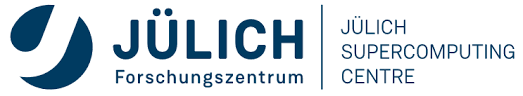

## Building your own Jupyter kernel is a three step process
1. Create/Pimp new virtual Python environment
   * venv
2. Create/Edit launch script for the Jupyter kernel
   * kernel.sh
3. Create/Edit Jupyter kernel configuration
   * kernel.json

### Settings

* Set kernel name
  - must be lower case
  - change if you like

In [ ]:
# INPUT NEEDED:
KERNEL_NAME=${USER}_kernel

export KERNEL_NAME=$(echo "${KERNEL_NAME}" | awk '{print tolower($0)}')
echo ${KERNEL_NAME} # double check

* List directories where JupyterLab will search for kernels

In [ ]:
# JUPYTER SEARCH PATH (for kernels-directory)
echo "jupyter search paths for kernels-directories"
if [ -z $JUPYTER_PATH ]; then
  echo "$HOME/.local/share/jupyter"
else
  tr ':' '\n' <<< "$JUPYTER_PATH"
fi

* Set kernel type
    - private kernel = "\${HOME}/.local/"  
    - project kernel = "\${PROJECT}/.local/"  
    - other kernel    = "\<your-path\>" (ensure it is part of $JUPYTER_PATH or your kernel will not be found by JuypterLab)

In [ ]:
# INPUT NEEDED:
export KERNEL_TYPE=private # private, project or other
export KERNEL_SPECS_PREFIX=/p/home/jusers/$USER/jureca/.local

###################
# project kernel
if [ "${KERNEL_TYPE}" == "project" ]; then
  export KERNEL_SPECS_PREFIX=${PROJECT}/.local
  echo "project kernel"
# private kernel
elif [ "${KERNEL_TYPE}" == "private" ]; then
  export KERNEL_SPECS_PREFIX=${HOME}/.local
  echo "private kernel"
else
  if [ ! -d "$KERNEL_SPECS_PREFIX" ]; then
    echo "ERROR: please create directory $KERNEL_SPECS_PREFIX"
  fi
  echo "other kernel"
fi
export KERNEL_SPECS_DIR=${KERNEL_SPECS_PREFIX}/share/jupyter/kernels

# check if kernel name is unique
if [ -d "${KERNEL_SPECS_DIR}/${KERNEL_NAME}" ]; then
  echo "ERROR: Kernel already exists in ${KERNEL_SPECS_DIR}/${KERNEL_NAME}"
  echo "       Rename kernel name or remove directory."
fi

echo ${KERNEL_SPECS_DIR}/${KERNEL_NAME} # double check

* Set directory for kernels virtual environment
  - change if you like

In [ ]:
# INPUT NEEDED:
export KERNEL_VENVS_DIR=${PROJECT}/${USER}/jupyter/kernels

###################
mkdir -p ${KERNEL_VENVS_DIR}
if [ "${KERNEL_TYPE}" != "private" ] && [ "${KERNEL_TYPE}" != "other" ]; then
  echo "Please check the permissions and ensure your project partners have read/execute permissions:"
  namei -l ${KERNEL_VENVS_DIR}
fi

echo ${KERNEL_VENVS_DIR} # double check
ls -lt ${KERNEL_VENVS_DIR}

---

## 1. Create/Pimp new virtual Python environment

* 1.1 - Load required modules

In [ ]:
module -q purge
module -q use $OTHERSTAGES        
module -q load Stages/Devel-2019a 2> /dev/null # any stage can be used
module -q load GCCcore/.8.3.0     2> /dev/null
module -q load Python/3.6.8                    # only Python is required
module list # double check

* 1.2 - Load extra modules you need for your kernel

In [ ]:
# module load <module you need>

* 1.3 - Create and activate a virtual environment for the kernel  
and ensure python packages installed in the virtual environment are always prefered

In [ ]:
if [ -d "${KERNEL_VENVS_DIR}/${KERNEL_NAME}" ]; then
  echo "ERROR: Directory for virtual environment already ${KERNEL_VENVS_DIR}/${KERNEL_NAME}"
  echo "       Rename kernel name or remove directory."
else
  python -m venv --system-site-packages ${KERNEL_VENVS_DIR}/${KERNEL_NAME}
  source ${KERNEL_VENVS_DIR}/${KERNEL_NAME}/bin/activate
  export PYTHONPATH=${VIRTUAL_ENV}/lib/python3.6/site-packages:${PYTHONPATH}
  echo ${VIRTUAL_ENV} # double check
fi

* 1.4 - Install Python libraries required for communication with Jupyter

In [ ]:
which pip
pip install --ignore-installed ipykernel
ls ${VIRTUAL_ENV}/lib/python3.6/site-packages/ # double check

* 1.5 - Install whatever else you need in your Python virtual environment (using pip)

In [ ]:
#pip install <python-package you need>

---

## 2. Create/Edit launch script for the Jupyter kernel

* 2.1 - Create launch script, which loads your Python virtual environment and starts the ipykernel process inside:

In [ ]:
echo '#!/bin/bash'"

# Load required modules
module purge
module use "'$OTHERSTAGES'"
module load Stages/Devel-2019a
module load GCCcore/.8.3.0
module load Python/3.6.8

# Load extra modules you need for your kernel (as you did in step 1.2)
#module load <module you need>
    
# Activate your Python virtual environment
source ${KERNEL_VENVS_DIR}/${KERNEL_NAME}/bin/activate
    
# Ensure python packages installed in the virtual environment are always prefered
export PYTHONPATH=${VIRTUAL_ENV}/lib/python3.6/site-packages:"'${PYTHONPATH}'"
    
exec python -m ipykernel "'$@' > ${VIRTUAL_ENV}/kernel.sh
chmod +x ${VIRTUAL_ENV}/kernel.sh

cat ${VIRTUAL_ENV}/kernel.sh # double check

---

## 3. Create/Edit Jupyter kernel configuration

* 3.1 - Create Jupyter kernel configuration directory and files

In [ ]:
python -m ipykernel install --name=${KERNEL_NAME} --prefix ${VIRTUAL_ENV}
export VIRTUAL_ENV_KERNELS=${VIRTUAL_ENV}/share/jupyter/kernels

* 3.2 - Adjust kernel.json file

In [ ]:
mv ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json.orig

echo '{
  "argv": [
    "'${KERNEL_VENVS_DIR}/${KERNEL_NAME}/kernel.sh'",
    "-m",
    "ipykernel_launcher",
    "-f",
    "{connection_file}"
  ],
  "display_name": "'${KERNEL_NAME}'",
  "language": "python"
}' > ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json

cat ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME}/kernel.json # double check

* 3.3 - Create link to kernel specs

In [ ]:
cd ${KERNEL_SPECS_DIR}
ln -s ${VIRTUAL_ENV_KERNELS}/${KERNEL_NAME} .

ls ${KERNEL_SPECS_DIR} # double check

---

## 4. Cleanup

In [ ]:
deactivate